In [6]:
%matplotlib inline

In [24]:
from linescanning import plotting,prf
import matplotlib.pyplot as plt
import numpy as np
import os
opj = os.path.join

In [10]:
# initiate size-response object
subject = "sub-005"
SI_ = prf.CollectSubject(
    subject,
    prf_dir=f"/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/prf/{subject}/ses-1",
    cx_dir=f"/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/pycortex/{subject}",
    hemi="lh",
    resize_pix=270,
    verbose=True,
    v1=True,
    model="norm",
    best_vertex=True)

SR_ = prf.SizeResponse(
    SI_.prf_stim, 
    SI_.norm_iter,
    subject_info=SI_)


Reading /data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/pycortex/sub-005/sub-005_model-norm_desc-best_vertices.csv
Design has 4 more volumes than timecourses, cutting design to (100, 100, 221)
Reading settings from '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/code/prf_analysis.yml'
Instantiate HRF with: [1, 1, 0]
Using constraint(s): ['tc', 'tc']
Inserting parameters from <class 'pandas.core.frame.DataFrame'> as 'norm_iter' in <linescanning.prf.CollectSubject object at 0x7fd0d4898c70>


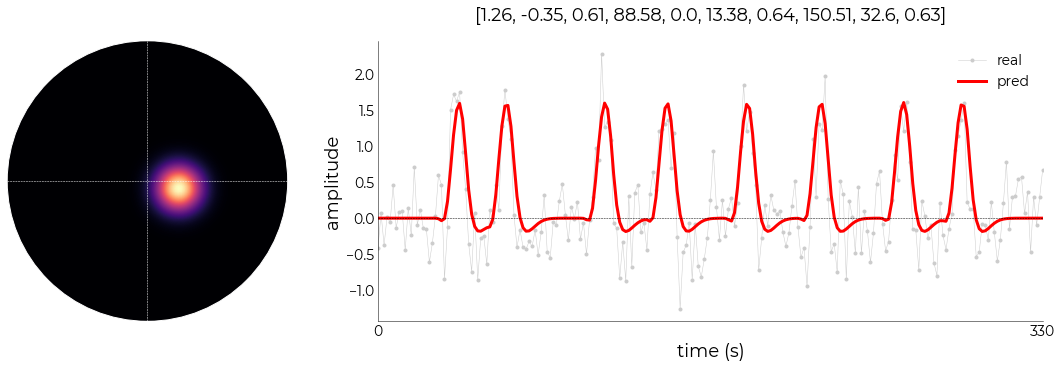

In [11]:
pars_new,prf_new,tc_bold,tc_new = SI_.plot_vox(
    model="norm",
    title="pars"
)

1.0


array([1.35126665])

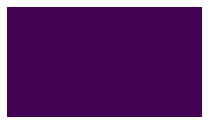

In [12]:
# get the response amplitude from full-field stimulation
SR_.make_stimuli(dt="full")
prf.plot_stims(
    SR_.stims_full, 
    n_rows=1,
    n_cols=1,
    extent=SR_.vf_extent)

print(np.amax(SR_.stims_full[0]))

sr_full = SR_.make_sr_function(center_prf=True, dt="full", normalize=None)
sr_full

In [13]:
# make the stimuli & curves and normalize by full-field stim
sr_act = SR_.make_sr_function(center_prf=True, dt="fill", normalize=sr_full)
sr_suppr = SR_.make_sr_function(center_prf=True, dt="hole", normalize=sr_full)

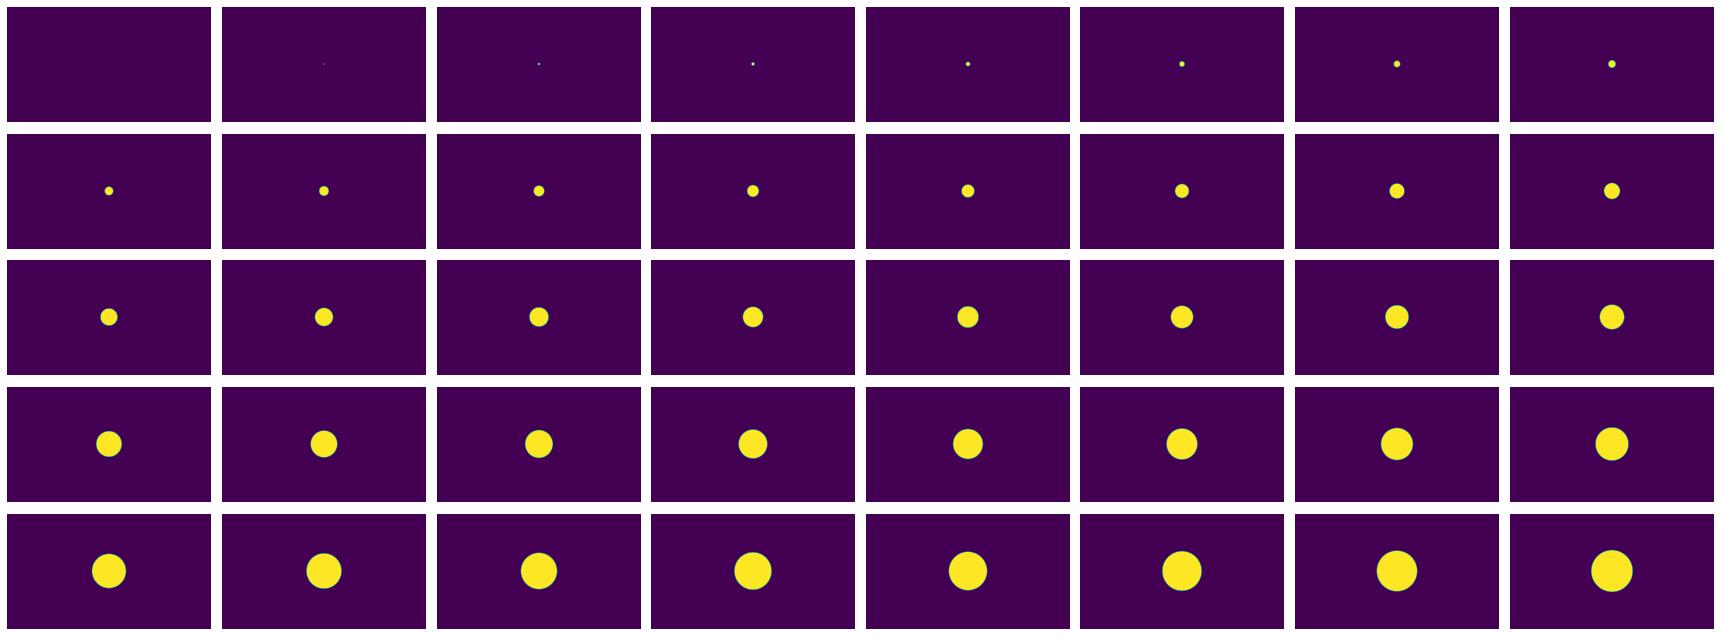

In [19]:
# y_ext = [-SR_.ss_deg_y/2,SR_.ss_deg_y/2]
# x_ext = [-SR_.ss_deg/2,SR_.ss_deg/2]
prf.plot_stims(
    SR_.stims_fill, 
    n_cols=8,
    figsize=(24,9),
    interval=5,
    extent=SR_.vf_extent)

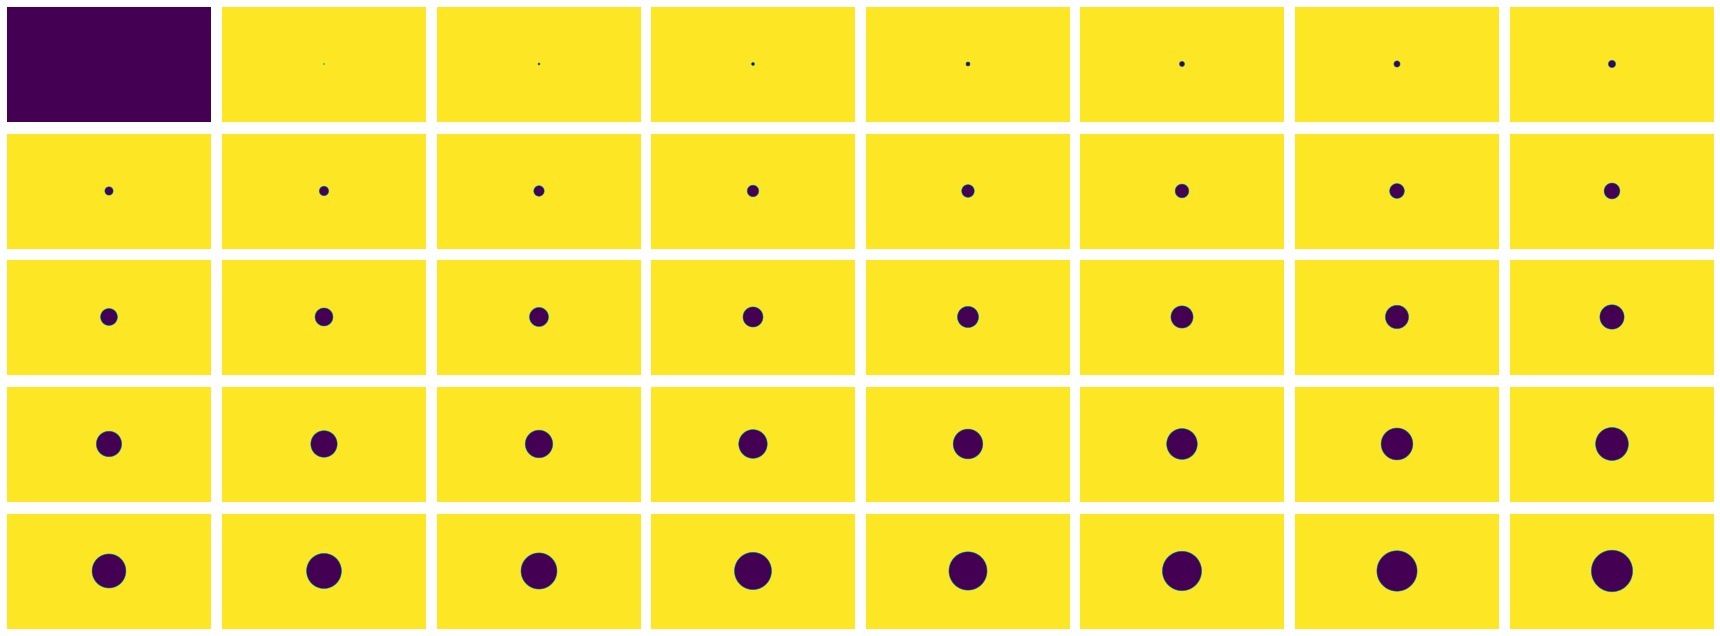

In [20]:
prf.plot_stims(
    SR_.stims_hole, 
    n_cols=8,
    figsize=(24,9),
    interval=5,
    extent=SR_.vf_extent)

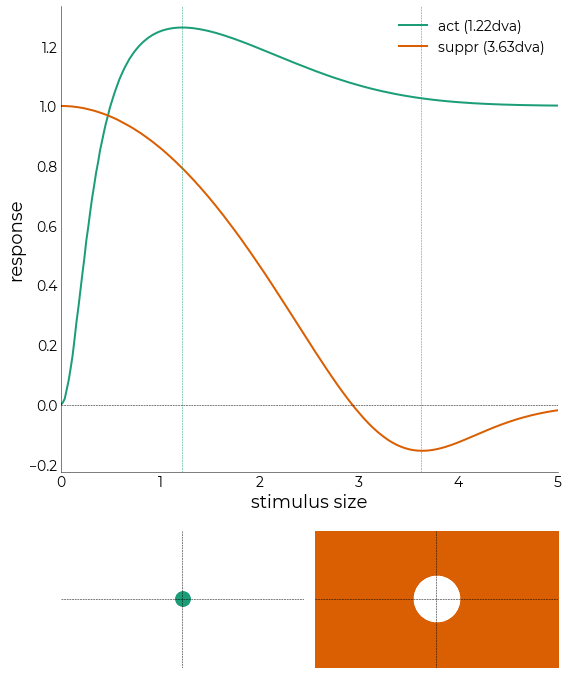

In [21]:
size_act = SR_.find_stim_sizes(sr_act)
size_suppr = SR_.find_stim_sizes(sr_suppr, t="min", dt="hole")

fig = plt.figure(figsize=(8,10), facecolor="white")
subfigs = fig.subfigures(nrows=2, height_ratios=[2,1])    

cols = ["#1B9E77","#D95F02"]
ax1 = subfigs[0].subplots()
plotting.LazyPlot(
    [sr_act,sr_suppr],
    axs=ax1,
    xx=SR_.stims_fill_sizes,
    line_width=2, 
    color=cols,
    labels=[f"act ({round(size_act,2)}dva)",f"suppr ({round(size_suppr,2)}dva)"],
    x_label="stimulus size",
    y_label="response",
    add_vline={
        "pos": [size_act,size_suppr],
        "color": cols},
    x_lim=[0,5],
    add_hline=0)

axs = subfigs[1].subplots(ncols=2)
for ix,(ii,el) in enumerate(zip([size_act,size_suppr],[False,True])):
    SR_.plot_stim_size(
        ii, 
        ax=axs[ix], 
        dt=["fill","hole"][ix],
        clip=False, 
        cmap=cols[ix],
        vf_extent=SR_.vf_extent)

plt.tight_layout()

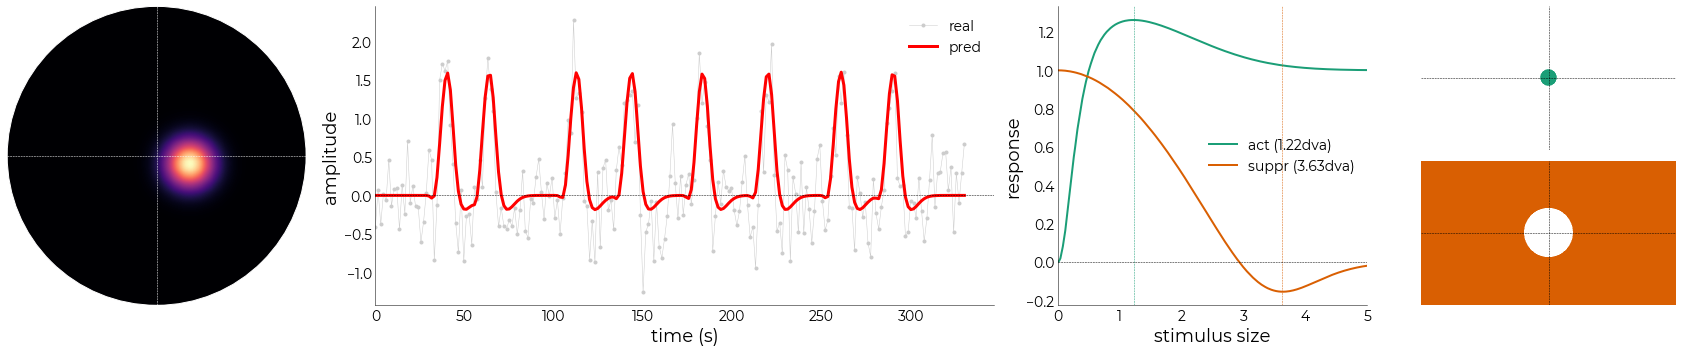

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure(constrained_layout=True, figsize=(24,5))
subfigs = fig.subfigures(ncols=2, width_ratios=[4,1])
gs00 = subfigs[0].subplots(ncols=3, gridspec_kw={"width_ratios": [10,20,10]})
gs01 = subfigs[1].subplots(nrows=2)

plotting.LazyPRF(
    prf_new, 
    [-5,5], 
    ax=gs00[0])  

plotting.LazyPlot(
    [tc_bold, tc_new],
    xx=np.arange(0,tc_bold.shape[0],1)*SI_.TR,
    color=['#cccccc', 'r'], 
    labels=['real', 'pred'], 
    add_hline='default', 
    axs=gs00[1],
    y_label="amplitude",
    x_label="time (s)",
    line_width=[0.5, 3],
    markers=['.', None])

plotting.LazyPlot(
    [sr_act,sr_suppr],
    axs=gs00[2],
    xx=SR_.stims_fill_sizes,
    line_width=2, 
    color=cols,
    labels=[f"act ({round(size_act,2)}dva)",f"suppr ({round(size_suppr,2)}dva)"],
    x_label="stimulus size",
    y_label="response",
    add_vline={
        "pos": [size_act,size_suppr],
        "color": cols},
    x_lim=[0,5],
    add_hline=0)

for ix,(ii,el) in enumerate(zip([size_act,size_suppr],[False,True])):
    SR_.plot_stim_size(
        ii, 
        ax=gs01[ix], 
        dt=["fill","hole"][ix],
        clip=False, 
        cmap=cols[ix],
        vf_extent=SR_.vf_extent)

plt.tight_layout()

# fig.tight_layout(rect=[0, 0, 0.91, 1])
# fig.savefig("/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/pycortex/sub-005/sub-005_hemi-L_desc-prf_sizeresponse.pdf",dpi=300,bbox_inches="tight")

In [21]:
SR_.save_target_params(
    hemi="L", 
    stim_sizes=[size_act,size_suppr])

In [34]:
# check if manually fitted data is the same as the pRF estimates from --v1

tester = "sub-001"
data_fn = opj(os.environ.get("PRF"),tester,"ses-1",f"{tester}_ses-1_task-2R_roi-V1_hemi-LR_desc-avg_bold.npy")
data = np.load(data_fn).T

man = prf.pRFmodelFitting(
    data,
    TR=1.5,
    verbose=True,
    design_matrix=opj(os.path.dirname(data_fn), "design_task-2R.mat")
)

man_pars = f"/data1/projects/MicroFunc/Jurjen/programs/project_repos/pRFline/data/{tester}/{tester}_acq-2DEPI_run-avg_model-norm_stage-iter_desc-prf_params.pkl"
man.load_params(man_pars, model="norm", stage="iter")

v1 = prf.pRFmodelFitting(
    data,
    design_matrix=opj(os.path.dirname(data_fn), "design_task-2R.mat"),
    TR=1.5,
    verbose=True
)

v1_pars = opj(os.path.dirname(data_fn), f"{tester}_ses-1_task-2R_roi-V1_model-norm_stage-iter_desc-prf_params.pkl")
v1.load_params(v1_pars, model="norm", stage="iter")

Reading design matrix from '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/prf/sub-001/ses-1/design_task-2R.mat'
Design has 4 more volumes than timecourses, cutting design to (100, 100, 116)
Reading settings from '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/code/prf_analysis.yml'
Instantiate HRF with: [1, 1, 0]
Using constraint(s): ['tc', 'tc']
Reading settings from pickle-file (safest option; overwrites other settings)
Inserting parameters from <class 'str'> as 'norm_iter' in <linescanning.prf.pRFmodelFitting object at 0x7fd0cd6761f0>
Reading design matrix from '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/prf/sub-001/ses-1/design_task-2R.mat'
Design has 4 more volumes than timecourses, cutting design to (100, 100, 116)
Reading settings from '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/code/prf_analysis.yml'
Instantiate HRF with: [1, 1, 0]
Using constraint(s): ['tc', 'tc']
Reading settings from pickle-file (safest option; overwrites other settin

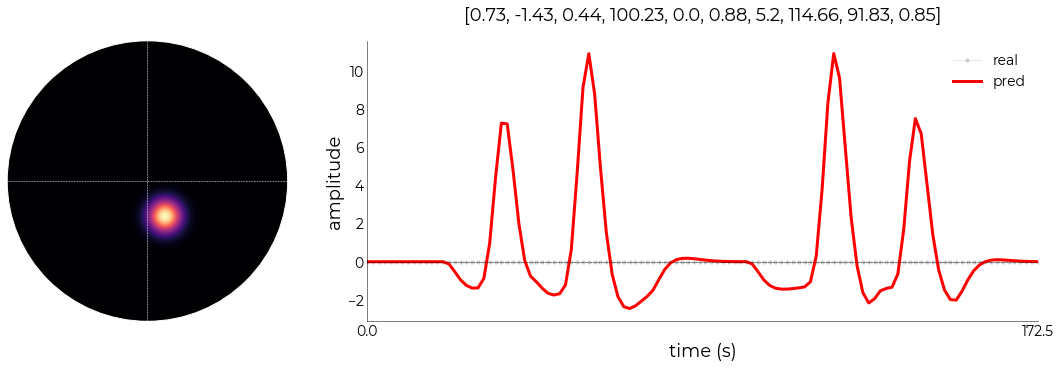

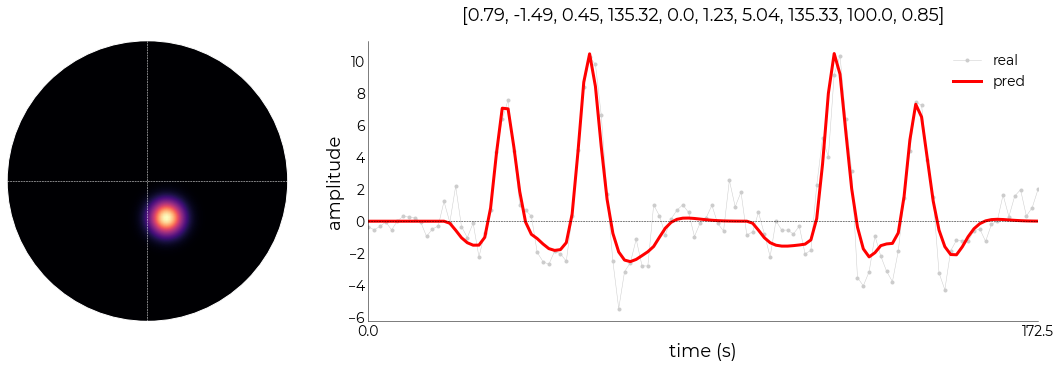

In [38]:
_,_,_,_ = man.plot_vox(
    vox_nr=68,
    model="norm",
    title="pars"
)

_,_,_,_ = v1.plot_vox(
    vox_nr=1053,
    model="norm",
    title="pars"
)

In [32]:
pars_new

array([  1.26,  -0.35,   0.61,  88.58,   0.  ,  13.38,   0.64, 150.51,
        32.6 ,   0.63])